<a href="https://colab.research.google.com/github/nawroz-m/ML_learning/blob/main/06_Transfer_learning_Internsorflow_Scalling_UP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this part the goal is to beat the original food101 paper with 10% of the training dataset(Leveraging the power of deep learning)
Our baseline to beat is 50.76% accuracy across all 101 classes


In [1]:
 # Download the 10% of 101 classe datasets
 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-11-15 05:33:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   118MB/s    in 18s     

2025-11-15 05:33:51 (86.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [18]:
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplt
import pathlib
import numpy as np
import random
import tensorflow as tf
import datetime

In [3]:
# unzip the downloaded dataset
zip_ref = zipfile.ZipFile('101_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [7]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [8]:
# walk through all the dataset file and folder
for dirpath, dirnames, filenames in os.walk('101_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')

There are 2 directories and 0 files in 101_food_classes_10_percent
There are 101 directories and 0 files in 101_food_classes_10_percent/test
There are 0 directories and 250 files in 101_food_classes_10_percent/test/baby_back_ribs
There are 0 directories and 250 files in 101_food_classes_10_percent/test/chicken_quesadilla
There are 0 directories and 250 files in 101_food_classes_10_percent/test/dumplings
There are 0 directories and 250 files in 101_food_classes_10_percent/test/apple_pie
There are 0 directories and 250 files in 101_food_classes_10_percent/test/tiramisu
There are 0 directories and 250 files in 101_food_classes_10_percent/test/mussels
There are 0 directories and 250 files in 101_food_classes_10_percent/test/ceviche
There are 0 directories and 250 files in 101_food_classes_10_percent/test/peking_duck
There are 0 directories and 250 files in 101_food_classes_10_percent/test/crab_cakes
There are 0 directories and 250 files in 101_food_classes_10_percent/test/chicken_curry
The

In [9]:
# get all the classes
class_path = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in class_path.glob('*')))


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

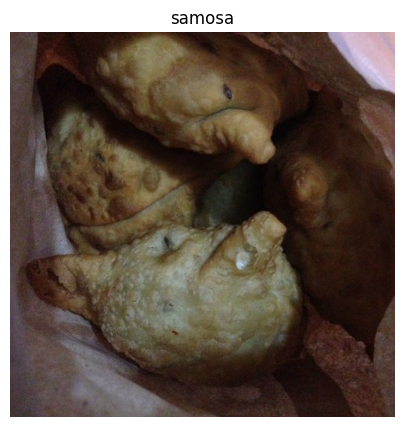

In [10]:
# Visualize a ranodm training dataset
# pick a random class
random_class = random.choice(class_names)
# list all the images within the slected class
image_dir = os.path.join(train_dir, random_class)
# list all the images in the directory
images = os.listdir(image_dir)
# pick a random image
random_image = random.choice(images)
# get the decode image with matplot
img = mplt.imread(os.path.join(image_dir, random_image))
# plot the image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(random_class)
plt.axis(False)


In [11]:
# Setup data inputs
IMAGE_SIZE=(224, 224)
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                    label_mode='categorical',
                                                                    batch_size=32,
                                                                    image_size=IMAGE_SIZE,
                                                                    shuffle=True,
                                                                    seed=42)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           label_mode='categorical',
                                                           batch_size=32,
                                                           image_size=IMAGE_SIZE,
                                                           shuffle=False, # don't shuffle the test data for prediction analysis
                                                           seed=42)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [39]:
len(train_data_10_percent), 7575/32

(237, 236.71875)

In [12]:
# look through images and label of training dataset
train_iter = iter(train_data_10_percent)
images, labels = next(train_iter)

In [13]:
labels[0].shape, images[0].shape

(TensorShape([101]), TensorShape([224, 224, 3]))

## Train the big mode model with 10% dataset of 101 food classes
Here are the steps we're going to take:
* Create a model checkpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers) functional EfficientnetB0 backbond-model(We'll create our own ouput)
* Compile the model
* Feature extract for 5 full pass(5 ecpochs on train dataset and valid on 15% of test data, to save epoch time)

In [14]:
# Chreate a model checkpoint callback
base_epoch = 5
checkpoint_filepath = 'ckpt/checkpoint.weights.h5'
create_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                             monitor='val_loss',
                                                             verbose=1,
                                                             save_weights_only=True,
                                                             save_freq='epoch')

In [15]:
# Create a data augmentation layer to build the data augmentation right on the model
augmented_layers = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMAGE_SIZE+(3,)),
    tf.keras.layers.RandomShear(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.Rescaling(1/255.)
], name='data_augmentation_layer')

(np.float64(-0.5), np.float64(264.5), np.float64(225.5), np.float64(-0.5))

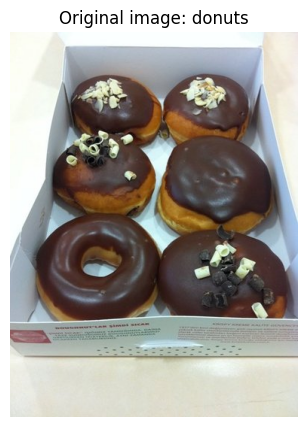

<Figure size 640x480 with 0 Axes>

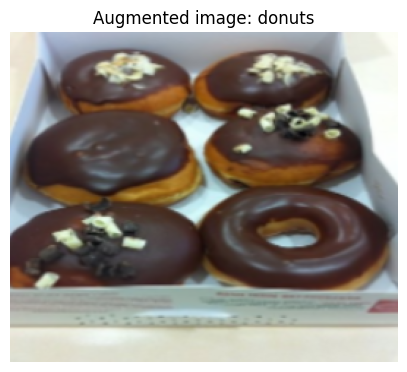

In [17]:
# Plot a random augmented iamge
random_class = random.choice(class_names)
# create iamge directory
image_dir = os.path.join(train_dir, random_class)
# list all the images in the directory
images = os.listdir(image_dir)
# pick a random image
random_image = random.choice(images)
# reade the image
image = mplt.imread(os.path.join(image_dir, random_image))

# Plot the original image
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.title(f'Original image: {random_class}')
plt.axis(False)
plt.figure()

#Plot the augmented image
reshaped_image = tf.image.resize(image, size=IMAGE_SIZE)
expand_dim = tf.expand_dims(reshaped_image, axis=0)
aug_image = augmented_layers(expand_dim)

plt.figure(figsize=(5,5))
plt.imshow(aug_image[0])
plt.title(f'Augmented image: {random_class}')
plt.axis(False)

In [21]:
datetime.datetime.now()

datetime.datetime(2025, 11, 15, 5, 41, 41, 315328)

In [22]:
# Create a tensorflow tesnsorboard callback
def create_tensorboard_callback(dir_path, experiment):
  currenttime = datetime.datetime.now()
  date_string = currenttime.strftime('%Y-%m-%d-%H-%M-%S')
  return tf.keras.callbacks.TensorBoard(os.path.join(dir_path, experiment, date_string))

In [27]:
# Build a headless model EfficientnetB0 backboned
# get the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# frezz the base model to make sure the layer remain un change while training
base_model.trainable = False
# Create an input layer to the model
inputs = tf.keras.layers.Input(shape=IMAGE_SIZE+(3,), name='Input_layer')
# Add the data augmentation layer on the model
x = augmented_layers(inputs)
# Add inputs to the base model
x = base_model(x, training=False)
print(f'The layer shape after adding base model {x.shape}')
# Add a global Average pooling 2D to the layer to make the base_model output is compatibale with new one
x = tf.keras.layers.GlobalAveragePooling2D()(x)
print(f'The layer shape after adding GlobalAveragePooling2D {x.shape}')
# Create an outputs
outputs = tf.keras.layers.Dense(len(class_names), activation=tf.keras.activations.softmax,
                                name='Output_layer')(x)
# build the headless model
model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

The layer shape after adding base model (None, None, None, 1280)
The layer shape after adding GlobalAveragePooling2D (None, 1280)


In [28]:
model_0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [33]:
for layer_num, layer in enumerate(model_0.layers):
  print(layer_num, layer.name, layer.trainable, len(layer.trainable_variables))

0 Input_layer True 0
1 data_augmentation_layer True 0
2 efficientnetb0 False 0
3 global_average_pooling2d_1 True 0
4 Output_layer True 2


In [34]:
# Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
# Train the model for 5 epoch and 15% of validation data
base_epoch=5
history_0 = model_0.fit(train_data_10_percent,
                        epochs=base_epoch,
                        callbacks=[create_tensorboard_callback('logs', 'featur_extraction_10_percent_all_data'),
                                   create_model_checkpoint],
                        validation_data=test_data,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_steps=int(len(0.15 * test_data))) # validate on 15% of data to mek faster training